# Plot data

In [1]:
# Load data:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
data_train=pd.read_excel("DST_BIL54_train.xlsx",header=None)
list_of_drive = data_train.iloc[1].values


In [2]:
# Create new column with time variable:
list_of_drive = list_of_drive[1:]

time = np.array([2018+1/12 * i for i in range(0, len(list_of_drive))])

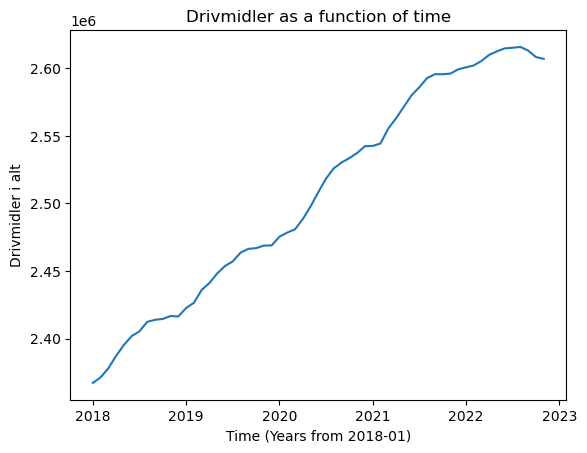

In [3]:

plt.plot(time,list_of_drive)
plt.title('Drivmidler as a function of time')
plt.xlabel('Time (Years from 2018-01)')
plt.ylabel('Drivmidler i alt')
plt.savefig("plot_data.png")

Notes
- Seems to be globally increasing somewhat linearly, stagnates towards the end and seems to be a slight harmonic structure 

# OLS

In [11]:
# calculate the parameters of an OLS regression:

# stack  with a columnn of ones:
data = np.array(list_of_drive)
time_inter = np.vstack((np.ones(len(time)), time.T)).T

# Calculate the parameters:
beta = np.linalg.inv(time_inter.T @ time_inter) @ time_inter.T @ data

In [12]:
beta

array([-109499932.7474847, 55437.78301393896], dtype=object)

In [13]:
# estimate the errors of the parameters:

# calculate the residuals:
residuals = data - time_inter @ beta

# calculate the variance of the residuals:
variance = residuals.T @ residuals / (len(time) - 2)

# calculate the variance of the parameters:
var_beta = variance * np.linalg.inv(time_inter.T @ time_inter)

# calculate the standard deviation of the parameters:
std_beta = np.sqrt(np.diag(var_beta))

std_beta

array([1.92155555e+06, 9.51068713e+02])

In [14]:
# forecaset of the drivmidler 
x_forecase = np.array([np.max(time)+1/12*i for i in range (1, 13)])
x_forecase = np.vstack((np.ones(len(x_forecase)), x_forecase.T)).T
y_forecase = x_forecase @ beta

# calculate the confidence interval:
t = stats.t.ppf(0.90, len(time) - 2)

# calculate the vmatrix based on variance and the x_forecase matrix:
vmatrix = variance * (1+x_forecase @ np.linalg.inv(time_inter.T @ time_inter) @ x_forecase.T)
y_forecase_upper = y_forecase + t * np.sqrt(np.diag(vmatrix))
y_forecase_lower = y_forecase - t * np.sqrt(np.diag(vmatrix))


In [15]:
# load the test data:

data_test=pd.read_excel("DST_BIL54_test.xlsx",header=None)
data_test = data_test.iloc[1].values
data_test = data_test[1:]

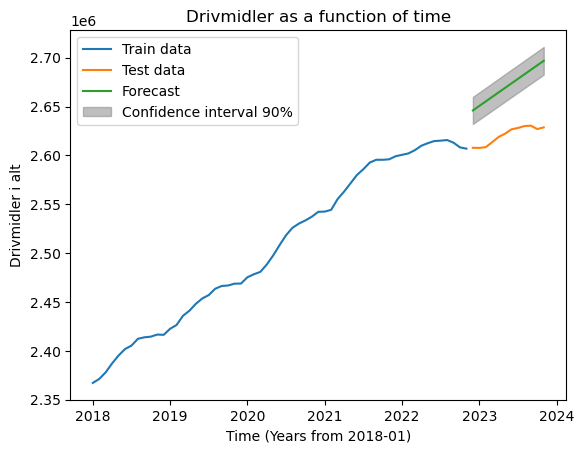

In [16]:
# plot the forecast data with the old data:
x_values = x_forecase[:,1]
plt.plot(time,list_of_drive)
plt.plot(x_values,data_test)
plt.plot(x_values,y_forecase)
plt.fill_between(x_values,list(y_forecase_lower),list(y_forecase_upper), color='gray', alpha=0.5)
plt.legend(["Train data",'Test data','Forecast','Confidence interval 90%'])
plt.xlabel('Time (Years from 2018-01)')
plt.ylabel('Drivmidler i alt')
plt.title('Drivmidler as a function of time')
plt.savefig('forecastOLS.png')


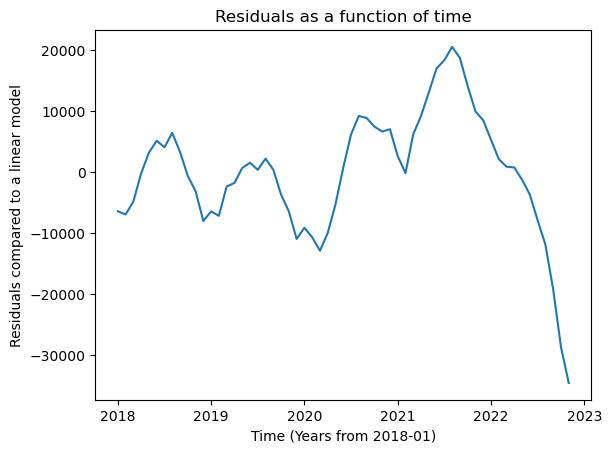

In [17]:
# investigate residuals:
plt.plot(time,residuals)
plt.title('Residuals as a function of time')
plt.xlabel('Time (Years from 2018-01)')
plt.ylabel('Residuals compared to a linear model')
plt.savefig('residuals.png')

# WLS

We will now use WLS to make the linear model in Eq. (1) as a local trend model, i.e., the observation
at the latest timepoint (xN = x59 = 2022.833) has weight λ0 = 1, the observation at the second
latest timepoint (xN −1 = x58 = 2022.750) has weight λ1 , the third latest observation (xN −2 = x57 =
2022.667) has weight λ2 etc.
We start by setting λ = 0.9.

In [25]:
# Creating the Sigma matrix for WLS
lamb = 0.9
Sigma = np.zeros((len(time),len(time)))
for i in range(len(time)):
    Sigma[i,i] = 1/(lamb**(len(time)-i))


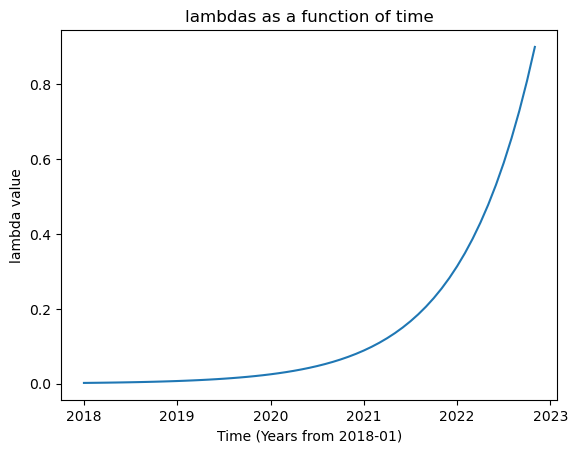

In [29]:
# Plot diagonals as a function of time: 

plt.plot(time,1/np.diag(Sigma))
plt.xlabel('Time (Years from 2018-01)')
plt.ylabel('lambda value')
plt.title("lambdas as a function of time")
plt.savefig("WLSLambdasVsTime.png")

In [30]:
np.sum(1/np.diag(Sigma))

8.982029897000858

In [37]:
#calculate the parameters: 

beta_WLS = np.linalg.inv(time_inter.T @ np.linalg.inv(Sigma) @ time_inter) @ time_inter.T @ np.linalg.inv(Sigma) @ data
beta_WLS

array([-84089781.0259155, 42868.564479107794], dtype=object)

In [46]:
# make prediction: 
y_pred_WLS_09 = x_forecase @ beta_WLS

array([2629752.5349462926, 2633324.915319562, 2636897.2956928164,
       2640469.676066071, 2644042.05643934, 2647614.4368125945,
       2651186.817185849, 2654759.1975591183, 2658331.5779323727,
       2661903.958305627, 2665476.3386788964, 2669048.719052151],
      dtype=object)

In [ ]:
legend = []
for lamb in  [0.9,0.8,0.7,0.6]:
    Sigma = np.zeros((len(time),len(time)))
    for i in range(len(time)):
        Sigma[i,i] = 1/(lamb**(len(time)-i))
    
    beta_WLS = np.linalg.inv(time_inter.T @ np.linalg.inv(Sigma) @ time_inter) @ time_inter.T @ np.linalg.inv(Sigma) @ data
    y_pred_WLS = x_forecase @ beta_WLS
    plt.plot(x_values,y_pred_WLS)
    legend.append(f"WLS_pred_lambda {lamb}")

plt.plot(time,list_of_drive)
plt.legend()

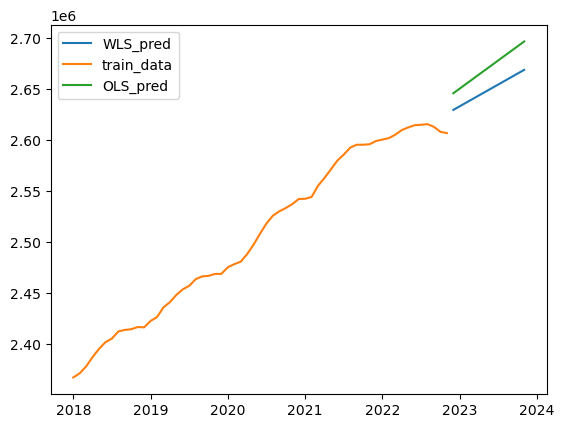

In [47]:

plt.plot(x_values,y_pred_WLS)
plt.plot(time,list_of_drive)
plt.plot(x_values,y_forecase)
plt.legend(["WLS_pred","train_data","OLS_pred"])